# Setup

In [1]:
# install transformers library for new runtimes
!pip install transformers

You should consider upgrading via the 'c:\programdata\anaconda3\python.exe -m pip install --upgrade pip' command.


In [1]:
# Import Libraries
import os
import io
import numpy as np
import pandas as pd
import sklearn
import itertools
import matplotlib.pyplot as plt
import transformers
import torch
import seaborn as sns
import scipy.stats as stats

from collections import defaultdict
from pylab import rcParams
from torch.utils import data
from torch import nn, optim
from transformers import BertModel, BertTokenizer, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [22]:
# Select Device for pytorch

device = torch.device('cuda:0')
#device = torch.device("cpu")

In [ ]:
# Upload Data
# from google.colab import files
# uploaded = files.upload()

In [2]:
# Read Data

# These commented out are for use uploading the data into google colab

#train = pd.read_csv(io.BytesIO(uploaded['training.1600000.processed.noemoticon.csv']),  encoding='latin-1', header=None)
#test = pd.read_csv(io.BytesIO(uploaded['testdata.manual.2009.06.14.csv']), header=None)

# These are if the data is already loaded into colab

train = pd.read_csv('C:\\Users\\Henru\\Desktop\\NLP Project\\Sentiment140\\training.1600000.processed.noemoticon.csv',  encoding='latin-1', header=None)
test = pd.read_csv('C:\\Users\\Henru\\Desktop\\NLP Project\\Sentiment140\\testdata.manual.2009.06.14.csv', header=None)

In [3]:
# Inspect training data

train.columns = ['Tweet Sentiment', 'Tweet ID', 'Tweet Date', 'Query', 'Tweet User', 'Tweet Text']
train.head()

,Tweet Sentiment,Tweet ID,Tweet Date,Query,Tweet User,Tweet Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
# Inspect test data

test.columns = ['Tweet Sentiment', 'Tweet ID', 'Tweet Date', 'Query', 'Tweet User', 'Tweet Text']
test.head()

,Tweet Sentiment,Tweet ID,Tweet Date,Query,Tweet User,Tweet Text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


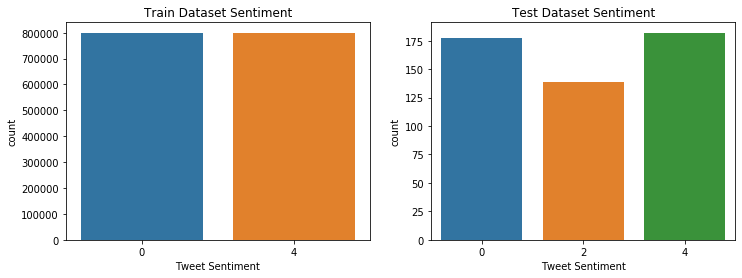

In [5]:
# Visualize Target Label

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].title.set_text('Train Dataset Sentiment')
axes[1].title.set_text('Test Dataset Sentiment')

sns.countplot(train['Tweet Sentiment'], ax=axes[0])
sns.countplot(test['Tweet Sentiment'], ax=axes[1])

We can see here that the dataset is balanced. Column 0 represents the polarity of the tweet. 0 = Negative, 2 = Neutral, 4 = Positive. Notice that the Train data only contains Negative or Positive sentiments, whereas the Test Dataset contains Neutral Sentiment classification.

In [73]:
# Adjusting target to in range 0, 1.

train['Tweet Sentiment'] = train['Tweet Sentiment'].replace([0,4],[0,1])
test['Tweet Sentiment'] = test['Tweet Sentiment'].replace([0,2,4],[0,0.5,1])

In [7]:
# Creating training data

small_train, small_train_test = train_test_split(train, test_size = 0.95, random_state = 2)

In [8]:
training_text = train['Tweet Text']
training_result = train['Tweet Sentiment']

test_train = test['Tweet Text']
test_answers = test['Tweet Sentiment']

For evaluation later, we also want to create a version of the test set without neutral sentiments, so that we can test our naive model solely on positive or negative sentiments.

In [9]:
# Creating test data without neutral sentiments

neutral_index = test_answers.index[test_answers == 0.5].tolist()

test_train_binary = test['Tweet Text'].drop(neutral_index).reset_index(drop=True)
test_answers_binary = test['Tweet Sentiment'].drop(neutral_index).reset_index(drop=True)


In [61]:
print(len(df_test))

8000


# Bernoulli Naive Bayes

In [74]:
# Define training function

def train_step(traindata,trainresult, vectorizer):

    
    trained_text = vectorizer.fit_transform(traindata)
    
    return BernoulliNB().fit(trained_text, trainresult)

# Define modular training function

def model_train_step(clfmodel,traindata,trainresult,vectorizer):

    
    trained_text = vectorizer.fit_transform(traindata)
    
    return clfmodel().fit(trained_text, trainresult)

vectorizer = CountVectorizer(binary = 'true')
classifier = train_step(training_text, training_result, vectorizer)
dummy_classifier = model_train_step(DummyClassifier, training_text, training_result, vectorizer)

In [75]:
vect = vectorizer.transform(['I am so happy that I am happy.'])
print(vect)

  (0, 64487)	1
  (0, 267348)	1
  (0, 563436)	1
  (0, 600330)	1


In [21]:
result = classifier.predict(vectorizer.transform(['I am so happy']))
print(result[0])

1


In [70]:
# Define text analyze

def analyze_text(classifier, vectorizer, text):
    return text, classifier.predict(vectorizer.transform([text]))

In [71]:
# Define a function to evaluate our classifier on our test data

def simple_eval(clf, test_text, test_result):
    total = len(test_text)
    corrects = 0
    
    for index in range(0, total):
        analysis_result = analyze_text(clf, vectorizer, test_text[index])
        text, result = analysis_result
        corrects +=1 if result[0] == test_result[index] else 0
        
    return 'Model Accuracy: ' + str(round(corrects * 100 / total, 2)) + '%'



In [16]:
# Evaluating Dummy Classifier

print('Dummy Classifier Evaluation:')
simple_eval(dummy_classifier,test_train, test_answers)

Dummy Classifier Evaluation:


'Model Accuracy: 35.14%'

In [17]:
# Evaluating our Bernoulli Naive Bayes

print('Bernoulli Naive Bayes Evaluation:')
simple_eval(classifier,test_train, test_answers)

Bernoulli Naive Bayes Evaluation:


'Model Accuracy: 57.43%'

In [18]:
# Evaluating our dummy classifier without neutral sentiments in the test data set
print('Dummy Classifier Evaluation without neutral sentiments in test data:')
simple_eval(dummy_classifier,test_train_binary, test_answers_binary)

Dummy Classifier Evaluation without neutral sentiments in test data:


'Model Accuracy: 46.8%'

In [19]:
# Evaluating our Bernoulli Naive Bayes Classifier without neutral sentiments in the test data set

print('Bernoulli Naive Bayes Evaluation without neutral sentiments in test data:')
simple_eval(classifier, test_train_binary, test_answers_binary)

Bernoulli Naive Bayes Evaluation without neutral sentiments in test data:


'Model Accuracy: 79.67%'

In [79]:
print('Bernoulli Naive Bayes Evaluation on NN Test Data: \n')
print('\'Model Accuracy: 76.98\'')

Bernoulli Naive Bayes Evaluation on NN Test Data: 

'Model Accuracy: 76.98'


# **Bert Model**

In [23]:
# Preparing Data

from torch.utils import data
class_names = ['Negative','Positive']
len(class_names)

2

In [24]:
# Bert Tokenizer using prtrained bert tokenizer

bert_tokenizer = transformers.BertTokenizerFast.from_pretrained('bert-base-cased')

In [25]:
# Sample Text

sample_text = 'This text is a test to visualize what happens using the tokenizer.'

tokens = bert_tokenizer.tokenize(sample_text)
print(tokens)

['This', 'text', 'is', 'a', 'test', 'to', 'visual', '##ize', 'what', 'happens', 'using', 'the', 'token', '##izer', '.']


In [26]:
# Changing Tokens to Token IDs

token_ids = bert_tokenizer.convert_tokens_to_ids(tokens)
print(token_ids)

[1188, 3087, 1110, 170, 2774, 1106, 5173, 3708, 1184, 5940, 1606, 1103, 22559, 17260, 119]


In [36]:
# Encoding

encoding = bert_tokenizer.encode_plus(
    sample_text,
    max_length = 140, # we set our max_length to 140 to match the max length of a tweet
    truncation = True,
    add_special_tokens = True,
    pad_to_max_length = True,
    return_attention_mask = True,
    return_token_type_ids = False,
    return_tensors = 'pt'
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [37]:
# Create Appropriate Dataset

class TwitterData(data.Dataset):

  def __init__(self, tweet, target, tokenizer, max_len):
    self.tweet = tweet
    self.target = target
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweet)
  
  def __getitem__(self, item):
    tweet = str(self.tweet[item])

    encoding = self.tokenizer.encode_plus(
      tweet,
      max_length = self.max_len, # we set our max_length to 140 to match the max length of a tweet
      truncation = True,
      add_special_tokens = True,
      pad_to_max_length = True,
      return_attention_mask = True,
      return_token_type_ids = False,
      return_tensors = 'pt'
    )

    return {
        'tweet_text': tweet,
        'input_ids':encoding['input_ids'].flatten(),
        'attention_mask':encoding['attention_mask'].flatten(),
        'targets': torch.tensor(self.target[item], dtype = torch.long)
    }

In [38]:
# Params 

MAX_LEN = 140
EPOCHS = 10

In [39]:
# Creating Training Data

df_train, df_test = train_test_split(small_train, test_size = 0.2, random_state = 2)
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = 2)

In [40]:
df_train.shape

(64000, 6)

In [64]:
df_test.head()

,Tweet Sentiment,Tweet ID,Tweet Date,Query,Tweet User,Tweet Text
1553072,1,2184553365,Mon Jun 15 16:04:43 PDT 2009,NO_QUERY,carramarie,Just finished washing the car..about to work o...
1252453,1,1996710890,Mon Jun 01 15:33:15 PDT 2009,NO_QUERY,cheskamarie_,@11640447 when I get on the computer... we got...
1010325,1,1880990684,Fri May 22 03:13:07 PDT 2009,NO_QUERY,pixelknipsr,Having lunch w/@superflausch &amp; @fellfrosch...
1124552,1,1974691304,Sat May 30 13:39:00 PDT 2009,NO_QUERY,cfal2348,@Jonasbrothers LOVE all of ur new songs. very ...
1200318,1,1985472881,Sun May 31 17:10:13 PDT 2009,NO_QUERY,dillllan,Just got back from the game. Boys Mt. Hope Lac...


In [41]:
# Define Data Loader

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = TwitterData(
      tweet = df['Tweet Text'].to_numpy(),
      target = df['Tweet Sentiment'].to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return data.DataLoader(
      ds,
      batch_size = batch_size,
  )

In [42]:
# Create data loaders

BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train,bert_tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(df_val,bert_tokenizer,MAX_LEN,BATCH_SIZE)
test_data_loader = create_data_loader(df_test,bert_tokenizer,MAX_LEN,BATCH_SIZE)

data = next(iter(train_data_loader))

In [43]:
data.keys()
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 140])
torch.Size([8, 140])
torch.Size([8])


In [44]:
# Select pretrained model

pretrained_model_name = 'bert-base-cased'
bert_model = BertModel.from_pretrained(pretrained_model_name)

In [45]:
last_hidden_state, pooled_output = bert_model(
    input_ids = encoding['input_ids'],
    attention_mask = encoding['attention_mask']
)

last_hidden_state.shape

torch.Size([1, 140, 768])

In [46]:
pooled_output.shape

torch.Size([1, 768])

In [47]:
# Building Sentiment Classifier

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(pretrained_model_name)
    self.drop = nn.Dropout(p = 0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, 2)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids = input_ids,
      attention_mask = attention_mask
    )

    output = self.drop(pooled_output)
    output = self.out(output)
    return self.softmax(output)

In [48]:
# Create model object with length 2 and transfer model to nvidia GPU

model = SentimentClassifier(2)
model = model.to(device)

In [49]:
# Transfer input ids and attention mask to GPU

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([8, 140])
torch.Size([8, 140])


In [50]:
model(input_ids, attention_mask)

tensor([[0.4064, 0.5936],
        [0.3523, 0.6477],
        [0.2843, 0.7157],
        [0.4444, 0.5556],
        [0.3757, 0.6243],
        [0.4179, 0.5821],
        [0.3122, 0.6878],
        [0.4703, 0.5297]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [51]:
# Using AdamW Optimizer
# Using paper values learning rate = 0.00002 and not correcting bias

optimizer = transformers.AdamW(model.parameters(), lr = 2e-5, correct_bias = False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [52]:
# Define Helper Function

def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):

  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    outputs = model(
        input_ids = input_ids,
        attention_mask = attention_mask
    )

    _, pred = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(pred == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)


In [53]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)

      outputs = model(
        input_ids = input_ids,
        attention_mask = attention_mask
      )

      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  
  return correct_predictions.double() / n_examples, np.mean(losses)

In [34]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1} / {EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)

  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model, 'model.pth')
    best_accuracy = val_acc



Epoch 1 / 10
----------
Train loss 0.5088364473022521 accuracy 0.798578125
Val loss 0.49937918430566786 accuracy 0.809125



C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type SentimentClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 2 / 10
----------
Train loss 0.4780398559123278 accuracy 0.8324375
Val loss 0.5018568460941315 accuracy 0.808125

Epoch 3 / 10
----------
Train loss 0.46497893185913564 accuracy 0.8465625
Val loss 0.5071630622744561 accuracy 0.803125

Epoch 4 / 10
----------
Train loss 0.45614500588551166 accuracy 0.855671875
Val loss 0.5025268984735012 accuracy 0.808875

Epoch 5 / 10
----------
Train loss 0.4515520079024136 accuracy 0.860546875
Val loss 0.4992877152562141 accuracy 0.813125

Epoch 6 / 10
----------
Train loss 0.44527706173062326 accuracy 0.8669687500000001
Val loss 0.502481094032526 accuracy 0.809

Epoch 7 / 10
----------
Train loss 0.44074203726649286 accuracy 0.871796875
Val loss 0.501567352950573 accuracy 0.810875

Epoch 8 / 10
----------
Train loss 0.43110237485170366 accuracy 0.88153125
Val loss 0.4950049730539322 accuracy 0.81575

Epoch 9 / 10
----------
Train loss 0.42648462515324354 accuracy 0.886203125
Val loss 0.5054766044020653 accuracy 0.805125

Epoch 10 / 10
--------

In [54]:
# Loading Model Checkpoint

model = SentimentClassifier(2)
model = torch.load('model.pth', map_location=torch.device('cpu'))
model = model.to(device)

In [55]:
def get_tweet(model, data_loader):
  model = model.eval()

  tweet_texts = []
  predictions = []
  predictions_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      tweets = d['tweet_text']
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)

      outputs = model(
        input_ids = input_ids,
        attention_mask = attention_mask
      )

      _, preds = torch.max(outputs, dim=1)

      tweet_texts.extend(tweets)
      predictions.extend(preds)
      predictions_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  predicitons_probs = torch.stack(predictions_probs).cpu()
  real_values = torch.stack(real_values).cpu()

  return tweet_texts, predictions, predictions_probs, real_values

In [56]:
test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

In [57]:
test_acc

tensor(0.8205, device='cuda:0', dtype=torch.float64)

In [58]:
test_loss

0.4924976945817471

In [1]:
y_review_tests, y_pred, y_pred_probs, y_test = get_tweet(model, test_data_loader)

NameError: name 'get_tweet' is not defined

In [2]:
print(classification_report(y_test, y_pred, target_names = class_names))

NameError: name 'classification_report' is not defined

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.title('Test Confusion Matrix')
plt.ylabel('True Sentiment')
plt.xlabel('Predicted Sentiment');

In [ ]:
self_tweets = pd.read_csv('stimulus_tweets.csv', encoding = 'unicode_escape')

In [ ]:
selftweet_dataloader = create_data_loader(self_tweets ,bert_tokenizer,MAX_LEN,BATCH_SIZE)

next(iter(selftweet_dataloader))

In [ ]:
self_tweet = get_tweet(model, selftweet_dataloader)

In [ ]:
self_test_acc, self_test_loss = eval_model(model, selftweet_dataloader, loss_fn, device, len(self_tweets))

In [ ]:
self_test_acc

In [83]:
p_val = '0.0000'
print('p-value: 0.0000')

p-value: 0.0000


In [86]:
print('p value:' + p_val)

p value:0.0000
